# Coursework final

- Andy Yuan
- Aidan Dignam
- Amelia Walker
- Owen Stevenson


# Question 1

In [ ]:
# Imports

import numpy as np
import polars as pl
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering, MiniBatchKMeans

# Dimensionality reduction
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.manifold import TSNE

# Tree-based models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor

# Model selection and evaluation
from sklearn.model_selection import (
    GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, 
    cross_validate, RepeatedKFold, KFold, RandomizedSearchCV
)

from sklearn.metrics import (
    silhouette_samples, silhouette_score, confusion_matrix, 
    roc_curve, roc_auc_score, classification_report, accuracy_score, r2_score, mean_squared_error
)
from sklearn.utils import resample

# Preprocessing and feature selection
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

# Linear models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, ElasticNet, ElasticNetCV
from sklearn import linear_model

# XGBoost
from xgboost import XGBRegressor, XGBClassifier

# Shap
import shap
shap.initjs() # Import Java engine.

# Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Statistical and optimization tools
from scipy.sparse import csr_matrix
from scipy.stats import zscore
from scipy.special import factorial
import scipy.optimize as so

# Text processing
import sklearn.feature_extraction.text as sktext
import re

# Dimensionality reduction
import umap.umap_ as umap

# Miscellaneous
import os
from itertools import chain, combinations
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import heapq


c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
householdspend = pl.read_csv("../Coursework Data/HouseholdSpend.csv")
demographics = pl.read_csv("../Coursework Data/DemoStats.csv")

In [3]:
# Combine data on the CODE variable
data_combined = householdspend.join(demographics, on="CODE", how="full")

# Must split into train and test before doing any replacement, 
train_data, test_data = train_test_split(data_combined, train_size=0.7, random_state = 2025)

In [4]:
# Dropping columns that were created from the merge
columns_to_drop = ["CODE", "CODE_right", "GEO", "GEO_right"]
ifexisting_cols = [col for col in columns_to_drop if col in data_combined.columns]
# Apply to train and test data
train_data = train_data.drop(ifexisting_cols)
test_data = test_data.drop(ifexisting_cols)

In [5]:
# removing columns for clustering
response_columns = ["HSHNIAGG", "HSAGDISPIN", "HSAGDISCIN", # spending variables
                    "HSEP001", "HSEP002", "HSEP003", "HSEP004", "HSEP005", "HSEP006", "HSEP007", # pension variables
                    "HSTT001", "HSTE001", "HSTX001", "HSTC001", "HSSH001S", "HSFD001S","HSHO001S", # summary variables
                    "HSHC001S", "HSHF001S", "HSTR001S", "HSRE001S", "HSPC001S", "HSCL001S", "HSED002S",
                    "HSRO001S", "HSTA001S", "HSGC001S", "HSME001S", "HSEP001S", "HSMG001S", "HSTE001ZBS",
                    "HSWH002S", "HSWH028S", "HSWH040S", "HSWH041S", "HSWH042S"] 
ifexisting_response_cols = [col for col in response_columns if col in data_combined.columns]

# Apply to test and train data, create new variable to cluster
clustering_train = train_data.drop(ifexisting_response_cols)
clustering_test = test_data.drop(ifexisting_response_cols)
# Done so we can use the train_data and test_data later in regression

In [6]:
# identify which columns are strings
string_columns = train_data.select(pl.col(pl.Utf8())).columns

# Replace NA with median values of the columns converted to string, using train data median values
for col in string_columns:
    median = ( # median of train data
        train_data[col].replace("NA", None)
        .cast(pl.Float64)
        .median()
    )
    train_data = train_data.with_columns( # will be used for regression
        pl.col(col).replace("NA", None)
        .cast(pl.Float64)
        .fill_null(median)
        .alias(col)
    )
    clustering_train = clustering_train.with_columns( # for clustering only
        pl.col(col).replace("NA", None)
        .cast(pl.Float64)
        .fill_null(median) 
    )
    test_data = test_data.with_columns( # will be used for regression
        pl.col(col).replace("NA", None)
        .cast(pl.Float64)
        .fill_null(median) # fill with median of train data
    )
    clustering_test = clustering_test.with_columns( # for clustering only
        pl.col(col).replace("NA", None)
        .cast(pl.Float64)
        .fill_null(median) # fill with median of train data
    )

In [7]:
# Taking a look at the data, with response columns
train_data.describe()

statistic,HSBASHHD,HSHNIAGG,HSAGDISPIN,HSAGDISCIN,HSTT001,HSTE001,HSTX001,HSTC001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSEP001S,HSMG001S,HSTE001ZBS,HSWH002S,HSWH028S,HSWH040S,HSWH041S,HSWH042S,HSSH001,HSSH002,HSSH003,HSSH004,HSSH053,HSSH054,…,ECYRIMINDI,ECYRIMNEPA,ECYRIMPAKI,ECYRIMSRI,ECYRIMSASO,ECYRIMOCE,ECYRIMAUSS,ECYRIMOCEO,ECYPIMHPOP,ECYPIMNI,ECYPIMIM,ECYPIMP01,ECYPIM0110,ECYPIM1115,ECYPIM1621,ECYPIM22CY,ECYPIMNPER,ECYAIMHPOP,ECYAIMNI,ECYAIMIM,ECYAIM_0_5,ECYAIM_514,ECYAIM1524,ECYAIM2544,ECYAIM45P,ECYAIMNPER,ECYGENHPOP,ECYGEN1GEN,ECYGEN2GEN,ECYGEN3GEN,ECYTCAHPOP,ECYTCACIT,ECYTCA_U18,ECYTCA_18P,ECYNCANCIT,ECYNCA_U18,ECYNCA_18P
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,…,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",18.505115,2.2626e6,1.7238e6,1.2392e6,2.4116e6,2.2009e6,423209.823681,1.6131e6,390207.179942,279255.161129,111887.37018,109876.727277,76415.761653,272453.143834,88293.198336,45491.797261,71054.161279,34485.648004,3588.37441,70743.670012,25943.550577,33441.056207,115633.350406,48956.401378,210629.749926,67992.441264,4823.41001,113608.694673,15133.147703,9072.056276,390207.179942,304787.019089,89380.861689,88180.613863,87567.023167,613.590696,…,0.475481,0.005647,0.038527,0.008743,0.000294,0.007242,0.005139,0.002103,46.035674,31.880372,11.747136,4.725555,2.363264,1.391048,1.632757,1.634511,2.408166,46.035674,31.880372,11.747136,1.065733,2.036413,2.229684,5.291205,1.124101,2.408166,46.035674,14.158953,7.460665,24.416056,46.035674,40.689125,7.785901,32.903224,5.34655,0.854351,4.492198
"""std""",70.886858,8.4449e6,6.4618e6,4.7287e6,9.3466e6,8.2262e6,1.6205e6,6.0583e6,1.3965e6,1.0718e6,430183.638559,439069.769635,296558.361743,1.1009e6,333775.377327,167739.493808,252953.878919,116835.006737,14768.113483,268292.706488,97612.564862,130138.646141,439481.741856,211961.009232,1.3148e6,351657.299377,40380.835359,927454.989631,52136.466083,36694.039599,1.3965e6,1.0508e6,292767.24044,288406.910856,286399.843871,2381.414019,…,2.486168,0.125415,0.353543,0.139325,0.021105,0.117661,0.095502,0.055302,175.157275,152.949196,32.650807,14.38387,7.179114,4.583791,5.747218,5.720639,10.499825,175.157275,152.949196,32.650807,3.394052,6.080894,6.507734,14.823808,3.896334,10.499825,175.157275,39.981126,25.023536,134.439204,175.157275,167.258769,35.236248,133.355852,17.88653,3.168746,15.052397
"""min""",0.0,0.0,0.0,0.0,-24249.492537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4599e7,0.0,0.0,-1.6806e7,-26676.98553,-116332.638685,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",3.0,267155.787608,214057.554764,150195

## a. Data clean


In [8]:
# Scale data
scaler = StandardScaler()
clustering_train_scaled = pd.DataFrame(scaler.fit_transform(clustering_train.to_pandas()), columns=clustering_train.columns)
clustering_test_scaled = pd.DataFrame(scaler.transform(clustering_test.to_pandas()), columns=clustering_test.columns)

## b. K-means

### Clusterer and elbow

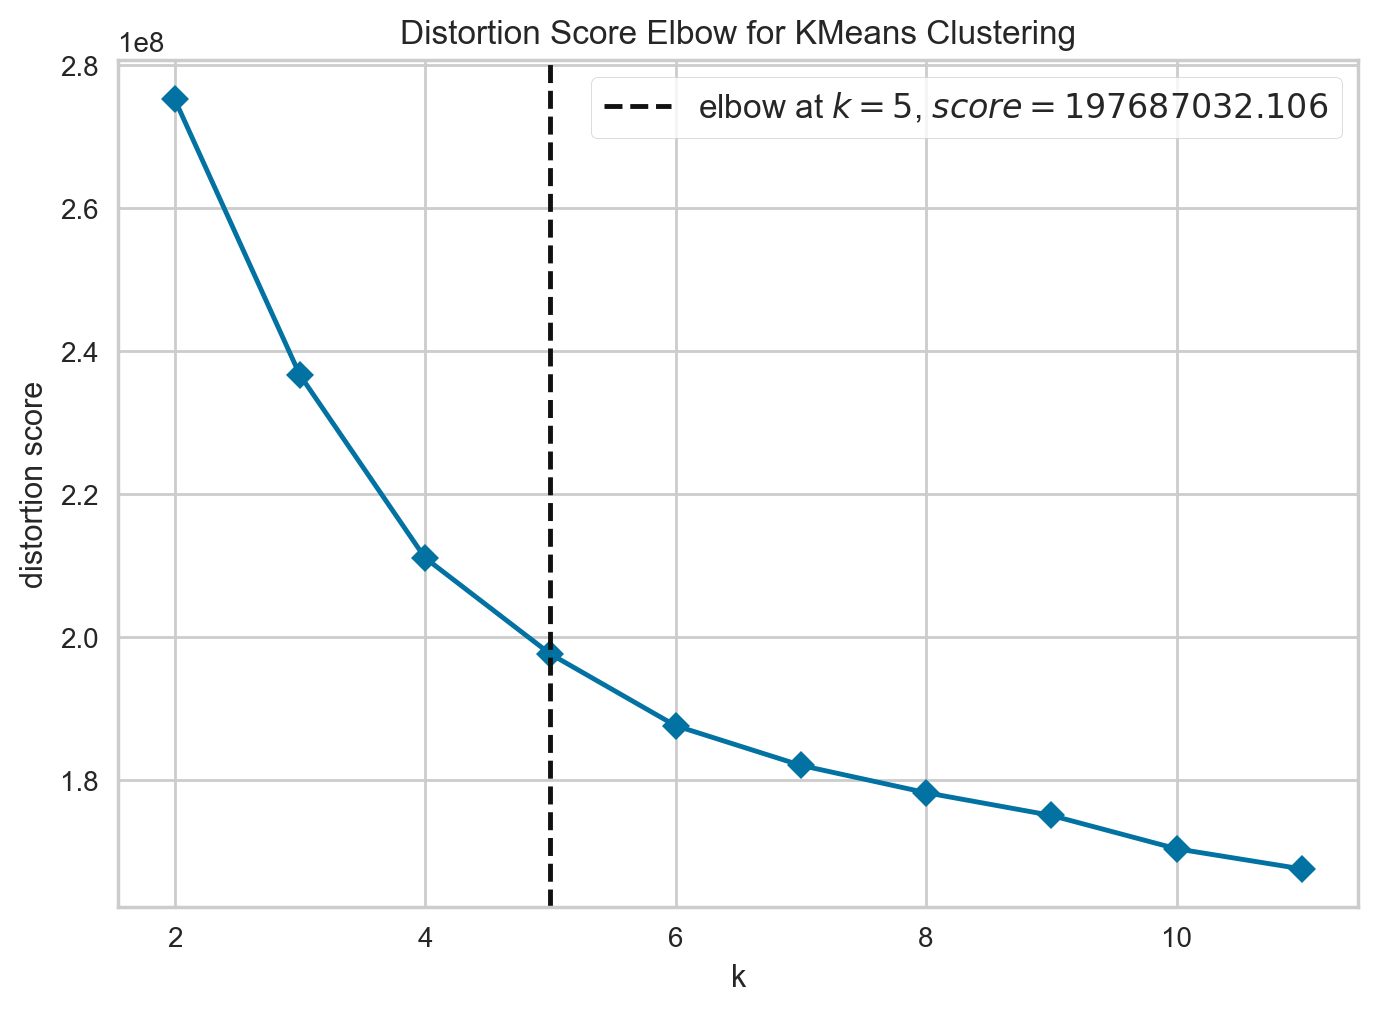

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
clustering_train_scaled_sample = clustering_train_scaled.sample(n=400000, random_state=2025) # sample for size of data set

# k-means clusterer created to use for visualizer
KClusterer = KMeans(n_clusters=3, # initialized with 3 for simplicity
                   verbose=0,
                   random_state=2025)

# Elbow visualizer
visualizer = KElbowVisualizer(KClusterer,
                              k=(2,12), # from 2 to 11 clusters
                              locate_elbow=True,
                              timings=False)
# Fit to scaled data sample
visualizer.fit(clustering_train_scaled_sample)
visualizer.show()
## Chosen: 5 clusters

### Silhouette

In [10]:
# Silhouette scorer
sil_scores = {}

for i in range(2,8):
    
    sample_scores = []
    
    for _ in range(10):
        current_sample = clustering_train_scaled.sample(n=10000, replace=False)
    
        Kmeansclusterer = KMeans(n_clusters=i,
                                verbose=0,
                                random_state=2025,
                                n_init=10)
        cluster_labels_silhouette = Kmeansclusterer.fit_predict(current_sample.values)
        sil_avg = silhouette_score(current_sample.values, cluster_labels_silhouette, metric = "cosine", n_jobs = -1)
        sample_scores.append(sil_avg)
        
    sil_scores[f'{i} clusters'] = np.mean(sample_scores)

print("Silhouette Scores:", sil_scores)
max_values = heapq.nlargest(3, sil_scores.values())
max_keys = [key for key, value in sil_scores.items() if value in max_values]
print("The greatest silhouette scores are from ", max_keys, "with scores of", max_values)

# Chosen: 2 clusters, decreases from there

Silhouette Scores: {'2 clusters': np.float64(0.21356446807568163), '3 clusters': np.float64(0.1963659949776813), '4 clusters': np.float64(0.1910799288702853), '5 clusters': np.float64(0.20305304086624448), '6 clusters': np.float64(0.19817050668002026), '7 clusters': np.float64(0.19902507078564796)}
The greatest silhouette scores are from  ['2 clusters', '5 clusters', '7 clusters'] with scores of [np.float64(0.21356446807568163), np.float64(0.20305304086624448), np.float64(0.19902507078564796)]


### Applying k-means according to best cluster number

In [11]:
# optimal kmeans function according to k-elbow and/or silhouette
KClusterer = KMeans(n_clusters=2, # put in optimal cluster amount
                   verbose=0,
                   random_state=2025)
# fitting to the training data (scaled)
KClusterer.fit(clustering_train_scaled)
# cluster means in unscaled units
unscaled_centroids = scaler.inverse_transform(KClusterer.cluster_centers_)
centroids_df = pd.DataFrame(unscaled_centroids, columns=clustering_train.columns)
print("Cluster Centroids (Original Units):\n", centroids_df)

# cluster assignments
train_cluster_labels = KClusterer.predict(clustering_train_scaled)
test_cluster_labels = KClusterer.predict(clustering_test_scaled)

# Create data_cluster_table for feature analysis
data_cluster_table = clustering_train.with_columns(
    pl.Series("cluster_label", train_cluster_labels)
)

Cluster Centroids (Original Units):
       HSBASHHD       HSSH001       HSSH002       HSSH003       HSSH004  \
0    16.813276  3.588552e+05  2.816312e+05  8.496350e+04  8.384051e+04   
1  1600.060000  2.969843e+07  2.195118e+07  4.218789e+06  4.145366e+06   

        HSSH053       HSSH054       HSSH005       HSSH006      HSSH007  ...  \
0  8.325013e+04    590.382615    165.248050    775.969093   181.771046  ...   
1  4.123057e+06  22308.826927  18009.837776  51548.139185  3865.648473  ...   

   ECYGEN1GEN  ECYGEN2GEN   ECYGEN3GEN   ECYTCAHPOP    ECYTCACIT  ECYTCA_U18  \
0   13.754674    7.002709    21.032000    41.789383    36.563566    6.948628   
1  392.084615  435.564615  3187.878462  4015.527692  3897.318462  790.480000   

    ECYTCA_18P  ECYNCANCIT  ECYNCA_U18  ECYNCA_18P  
0    29.614938    5.225817    0.835307    4.390510  
1  3106.838462  118.209231   18.656923   99.552308  

[2 rows x 949 columns]


## c. Linear dimensionality reductions

### i. Applying PCA

In [12]:
## PCA
nPCA = PCA(n_components=10)
nPCA.fit(np.asarray(clustering_train_scaled))
total_variance = np.sum(nPCA.explained_variance_ratio_) * 100
print('The total explained variance of the first %i components is %.3f percent' % (nPCA.n_components_, total_variance))

The total explained variance of the first 10 components is 69.211 percent


### ii. Plot the data of the first two PCs in a scatterplot (scaled data)

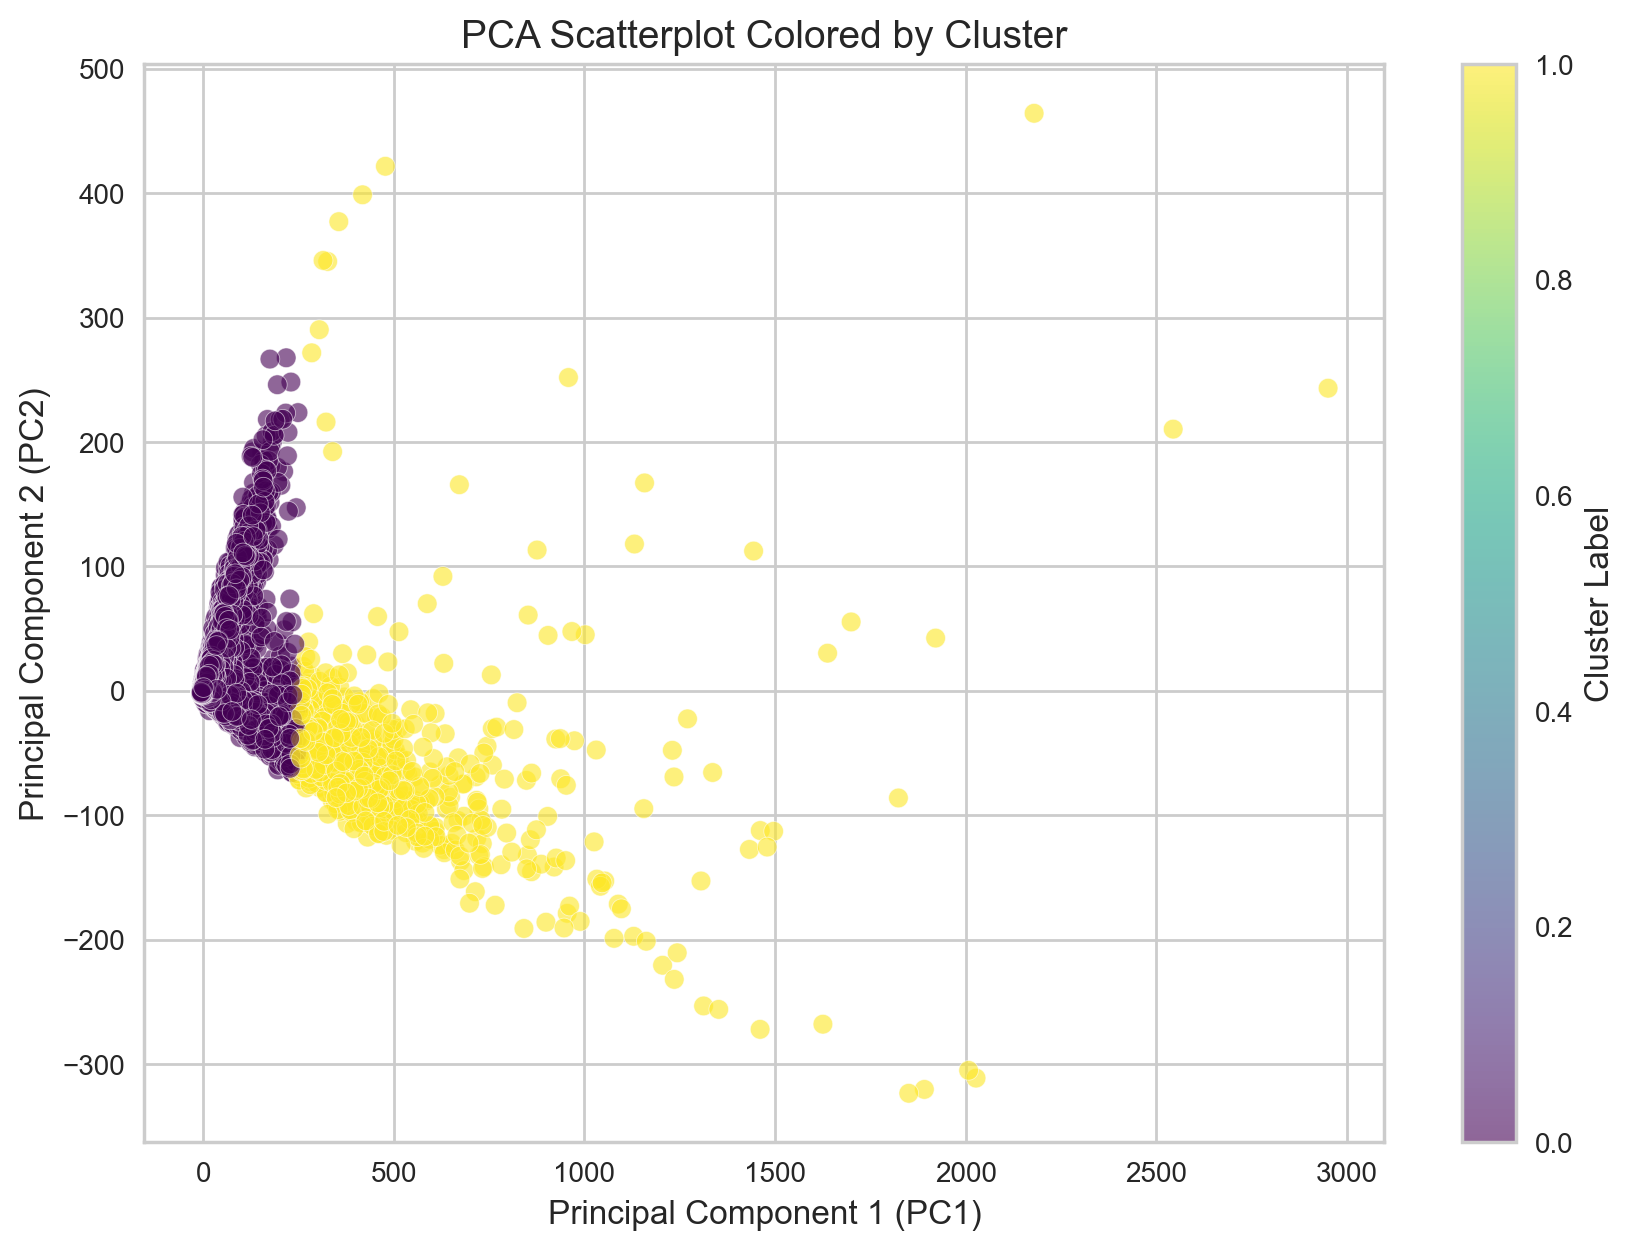

In [13]:
# Plot the data of the first two PCs in a scatterplot (scaled data)
pca_components = nPCA.transform(np.asarray(clustering_train_scaled))
pc1 = pca_components[:, 0]  # First principal component
pc2 = pca_components[:, 1]  # Second principal component
pc3 = pca_components[:, 2]  # Third principal component

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    pc1, 
    pc2, 
    c=train_cluster_labels, 
    cmap='viridis',  # You can change to 'plasma', 'rainbow', etc.
    alpha=0.6,       # Slightly transparent points
    edgecolors='w',  # White edges for better visibility
    s=50            # Point size
)

plt.xlabel('Principal Component 1 (PC1)', fontsize=12)
plt.ylabel('Principal Component 2 (PC2)', fontsize=12)
plt.title('PCA Scatterplot Colored by Cluster', fontsize=14)

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label', fontsize=12)

plt.show()

### Interpretation

eiosdfgjiopefoaishrgipjgwrig9upafg98 249tu 490u ridgjkl sdfgajkln dg890 wet4t 24wt 

### iii. Calculate average value of first three components, put into table

In [14]:
# Calculate average value of first three components, put into table
pca_df = pd.DataFrame({
    'PC1': pc1,
    'PC2': pc2,
    'PC3': pc3,
    'Cluster': train_cluster_labels # from KClusterer.fit(clustering_train_scaled)
})

# 1. Get PCA loadings (feature contributions)
loadings = pd.DataFrame(
    nPCA.components_.T[:, :3],
    columns=['PC1', 'PC2', 'PC3'],
    index=clustering_train.columns
)

pca_cluster_means = pca_df.groupby('Cluster').mean().reset_index()
feature_means = data_cluster_table.group_by("cluster_label").mean()

def name_cluster(row):
    # Find dominant PC
    pc_scores = {'PC1': row['PC1'], 'PC2': row['PC2'], 'PC3': row['PC3']}
    dominant_pc = max(pc_scores.keys(), key=lambda k: abs(pc_scores[k]))
    
    # Get top 3 features for this PC
    top_features = loadings[dominant_pc].abs().nlargest(3).index.tolist()
    
    # Describe feature trends
    trends = []
    for feat in top_features:
        feat_mean = feature_means.select(pl.col(feat)).mean().item()
        cluster_feat_val = feature_means.filter(pl.col("cluster_label") == row['Cluster']).select(feat).item()
        trend = "High" if cluster_feat_val > feat_mean else "Low"
        trends.append(f"{trend} {feat}")
    
    direction = "High" if pc_scores[dominant_pc] > 0 else "Low"
    return f"{direction} {dominant_pc} ({', '.join(trends)})"

# Apply naming and merge results
pca_cluster_means['Cluster_Name'] = pca_cluster_means.apply(name_cluster, axis=1)
final_results = pca_cluster_means.merge(
    feature_means.to_pandas(), 
    left_on='Cluster',
    right_on='cluster_label'
)

print("PCA Component Averages with Cluster Interpretation:")
print(pca_cluster_means[['Cluster', 'Cluster_Name', 'PC1', 'PC2', 'PC3']])

print("\nDetailed Feature Means per Cluster:")
display(feature_means.to_pandas().style.background_gradient(cmap='Blues'))

PCA Component Averages with Cluster Interpretation:
   Cluster                                       Cluster_Name         PC1  \
0        0  Low PC1 (Low ECYBAS12HP, Low ECYBAS15HP, Low E...   -0.533397   
1        1  High PC1 (High ECYBAS12HP, High ECYBAS15HP, Hi...  498.627127   

         PC2       PC3  
0   0.060467 -0.002375  
1 -56.525617  2.220625  

Detailed Feature Means per Cluster:


## d. UMAP

### Choice of parameters

In [15]:
# best parameters to use: {'n_neighbors': 5, 'min_dist': 0.1, 'metric': 'euclidean'}

# Define parameter grid
param_grid = {
    'n_neighbors': [5, 15, 30, 50],
    'min_dist': [0.01, 0.1, 0.5],
    'metric': ['euclidean', 'cosine']
}

clustering_train_scaled_sample = clustering_train_scaled.sample(n=10000, random_state=2025)
jittered_clustering = clustering_train_scaled_sample + np.random.normal(0, 1e-5, clustering_train_scaled_sample.shape)
train_labels_umap = KClusterer.predict(jittered_clustering)

best_score = -1
best_params = {}
best_embedding = None

# Grid search (small-scale for demonstration)
for n in param_grid['n_neighbors']:
    for d in param_grid['min_dist']:
        for m in param_grid['metric']:
            reducer = umap.UMAP(n_neighbors=n, min_dist=d, metric=m, random_state=2025, n_jobs=1, verbose=0)
            embedding = reducer.fit_transform(jittered_clustering)
            score = silhouette_score(embedding, train_labels_umap)
            if score > best_score:
                best_score = score
                best_params = {'n_neighbors': n, 'min_dist': d, 'metric': m}
                best_embedding = embedding

print(f"Best parameters: {best_params}, Silhouette score: {best_score:.3f}")

c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-pack

Best parameters: {'n_neighbors': 5, 'min_dist': 0.01, 'metric': 'euclidean'}, Silhouette score: 0.240


### Plot UMAP

c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


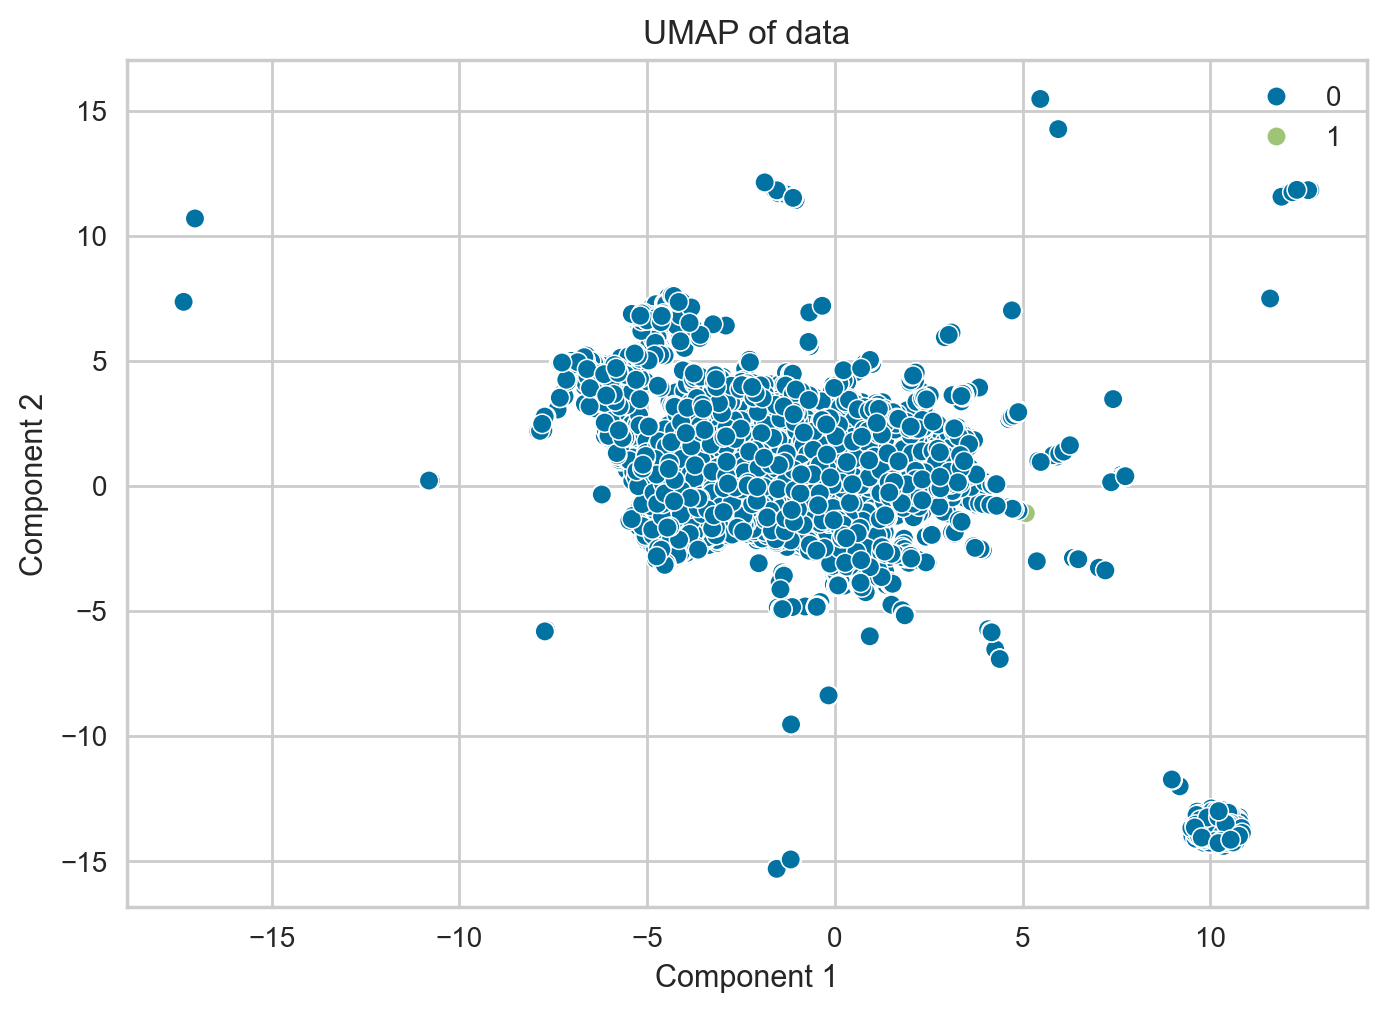

In [16]:
reducer = umap.UMAP(n_neighbors=5,              # Number of neareast neighbours to use. (set to best)
                    n_components=2,              # Number of components. UMAP is robust to larger values
                    metric='euclidean',             # Metric to use. (set to best)
                    n_epochs=1000,               # Iterations. Set to convergence. None implies either 200 or 500.
                    min_dist=0.1,                # Minimum distance embedded points. Smaller makes clumps, larger, sparseness. (set to best)
                    spread=1.0,                  # Scale to combine with min_dist
                    low_memory=False,             # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    verbose=0                 # Verbosity
                   )
UMAP_embedding = reducer.fit_transform(jittered_clustering)

sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=train_labels_umap)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP of data")
plt.show()

# Question 2


## a. Regularized elastic net regularized linear regression

In [17]:
# Target variable creation (proportion of income spent on total personal insurance premiums and retirement/pension contributions)
# personal insurance and pension columns
personal_insur_pension_col = ["HSEP001S"]
# checking if they exist
ifexisting_response_cols = [col for col in personal_insur_pension_col if col in train_data.columns]
print(ifexisting_response_cols)
print(train_data.filter(pl.col("HSHNIAGG") == 0).height)
print(train_data.filter(pl.col("HSEP001S") == 0).height)
print(test_data.filter(pl.col("HSHNIAGG") == 0).height)
print(test_data.filter(pl.col("HSEP001S") == 0).height)
# Some households had no spending AND no income, since the numbers line up, I will assume this is the case

['HSEP001S']
64812
64812
27897
27897


In [18]:
# removing columns for clustering
response_columns = ["HSAGDISPIN", "HSAGDISCIN", # spending variables
                    "HSEP001", "HSEP002", "HSEP003", "HSEP004", "HSEP005", "HSEP006", "HSEP007", # pension variables
                    "HSTT001", "HSTE001", "HSTX001", "HSTC001", "HSSH001S", "HSFD001S","HSHO001S", # summary variables
                    "HSHC001S", "HSHF001S", "HSTR001S", "HSRE001S", "HSPC001S", "HSCL001S", "HSED002S",
                    "HSRO001S", "HSTA001S", "HSGC001S", "HSME001S", "HSMG001S", "HSTE001ZBS",
                    "HSWH002S", "HSWH028S", "HSWH040S", "HSWH041S", "HSWH042S"] 
ifexisting_response_cols_to_delete = [col for col in response_columns if col in data_combined.columns]

# Apply to test and train data, create new variable to cluster
train_data = train_data.drop(ifexisting_response_cols_to_delete)
test_data = test_data.drop(ifexisting_response_cols_to_delete)
# Done so we can use the train_data and test_data later in regression

In [19]:
# Filling 0 with 1 to avoid division by 0
train_data = train_data.with_columns( 
    pl.col("HSHNIAGG").replace(0, None)
    .alias("HSHNIAGG")
)
# Filling 0 with 1 to avoid division by 0
test_data = test_data.with_columns(
    pl.col("HSHNIAGG").replace(0, None)
    .alias("HSHNIAGG")
)

# Create response for train data
train_data = train_data.with_columns(
    (pl.col("HSEP001S") / pl.col("HSHNIAGG"))
    .alias("Proportion_spend")
)
# Create response for test data
test_data = test_data.with_columns(
    (pl.col("HSEP001S") / pl.col("HSHNIAGG"))
    .alias("Proportion_spend")
)

median_df = train_data.select(pl.median("Proportion_spend"))
median = median_df.item()

train_data = train_data.with_columns( 
    pl.col("Proportion_spend").fill_null(median)
    .alias("Proportion_spend")
)
# Filling 0 with 1 to avoid division by 0
test_data = test_data.with_columns(
    pl.col("Proportion_spend").fill_null(median)
    .alias("Proportion_spend")
)

In [20]:
# drop variables we created response from
train_data = train_data.drop(["HSHNIAGG", "HSEP001S"])
test_data = test_data.drop(["HSHNIAGG", "HSEP001S"])

In [ ]:
# Convert Polars to Pandas and scale
train_data_pd = train_data.to_pandas()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_data_pd.drop('Proportion_spend', axis=1))
y = train_data_pd['Proportion_spend']
X_pca = nPCA.transform(X_scaled)

In [ ]:
# Grid search for parameters - PCA covariates
elastic_net_pca = ElasticNet(fit_intercept=True, random_state=2025)
param_dist = {
    'alpha': np.logspace(-3, 1, 20),
    'l1_ratio': np.linspace(0, 1, 11) # 0=Ridge, 1=LASSO
}

kf_pca = KFold(n_splits=5, shuffle=True, random_state=123)

# 4. GridSearchCV
grid_search_pca = GridSearchCV(
    estimator=elastic_net_pca,
    param_grid=param_dist,
    scoring='neg_mean_squared_error',
    cv=kf_pca,
    n_jobs=2, 
    verbose=0  
)

# 5. Fit on PCA-transformed data
grid_search_pca.fit(X_pca, y)

# Best model
print(f"Best alpha: {grid_search_pca.best_params_['alpha']}")
print(f"Best l1_ratio: {grid_search_pca.best_params_['l1_ratio']}")

# Get best Elastic Net coefficients (for PCA features)
best_coefs_pca = grid_search_pca.best_estimator_.coef_ 
best_elastic_net_model_pca = grid_search_pca.best_estimator_

# Transform back to original feature space (approximate)
original_feature_importance_pca = np.abs(nPCA.components_.T @ best_coefs_pca)

# Create a DataFrame for interpretation
importance_df_pca = pd.DataFrame({
    'Feature': clustering_train.columns,
    'Importance': original_feature_importance_pca
}).sort_values('Importance', ascending=False)

print("Top influential original features:")
print(importance_df_pca.head(10))

Best alpha: 0.3359818286283781
Best l1_ratio: 0.0
Top influential original features:
       Feature  Importance
316  ECYHTAAVG    0.000288
253  ECYPTAAVG    0.000283
369  ECYMTNAVG    0.000274
337  ECYHMAAVG    0.000267
274  ECYPMAAVG    0.000263
358  ECYHFAAVG    0.000243
295  ECYPFAAVG    0.000239
534   ECYACTER    0.000233
509  ECYPNIAVG    0.000170
533   ECYACTPR    0.000165


c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.245e+01, tolerance: 1.359e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# test data - PCA covariates
# Convert Polars to Pandas and sample
test_data_pd = test_data.to_pandas()
X_test_scaled = scaler.transform(test_data_pd.drop('Proportion_spend', axis=1))
y_test = test_data_pd['Proportion_spend']
X_test_pca = nPCA.transform(X_test_scaled)  # Output shape: (n_samples, 10)

# predicted values
y_test_pred_pca = best_elastic_net_model_pca.predict(X_test_pca)

# mse and r-squared
test_mse_pca = mean_squared_error(y_test, y_test_pred_pca)
test_r2_pca = r2_score(y_test, y_test_pred_pca)

print(f"\nTest set performance:")
print(f"PCA MSE: {test_mse_pca:.4f}")
print(f"PCA R²: {test_r2_pca:.4f}")


Test set performance:
PCA MSE: 0.0002
PCA R²: 0.0839


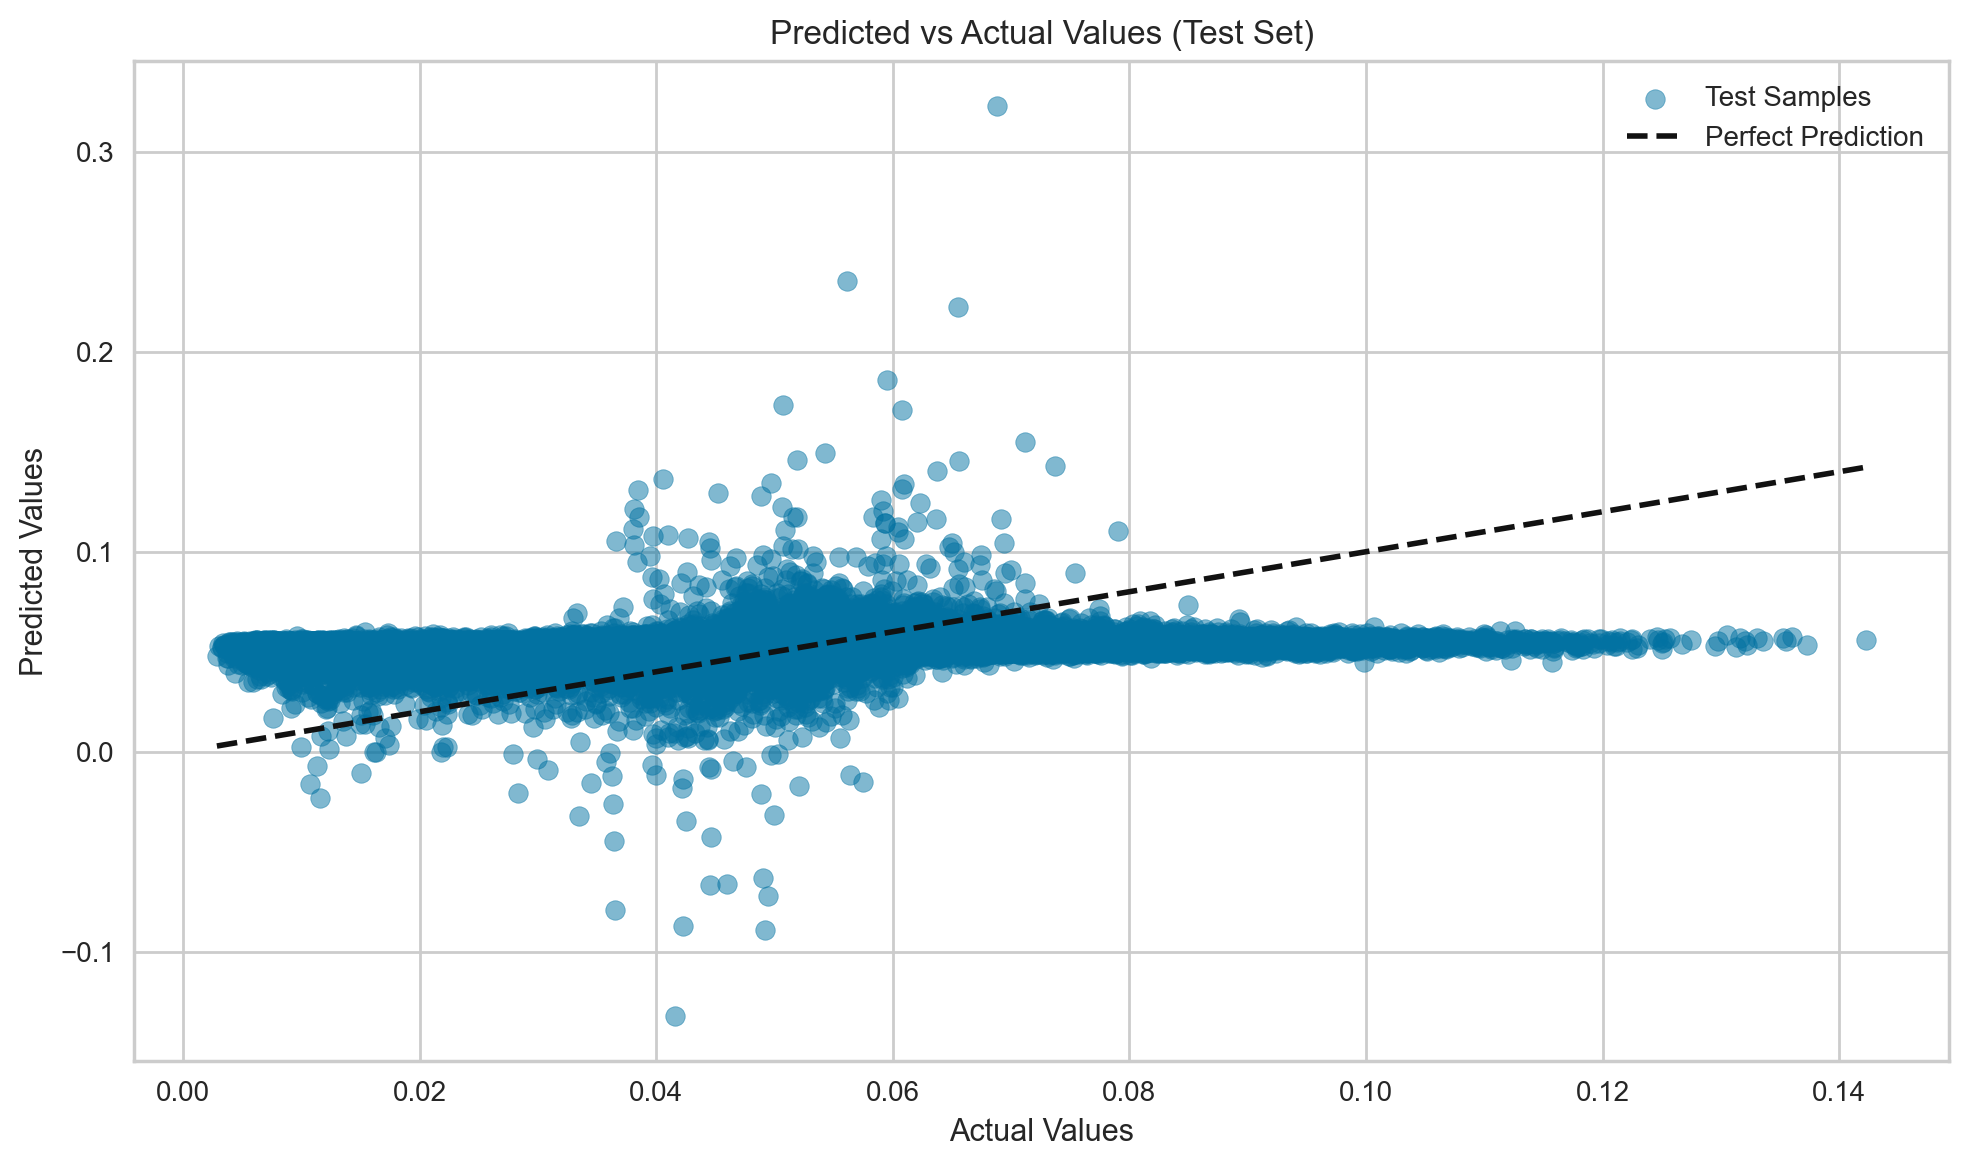

In [ ]:
# Scatter plot of predicted vs actual on test - PCA
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_pca, alpha=0.5, label='Test Samples')
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Bootstrapped Confidence Intervals
n_bootstraps = 1000  # Reduced from 10000 for speed
bootstrap_scores_pca = []

for _ in range(n_bootstraps):
    # Resample with replacement
    X_bs_pca, y_bs_pca = resample(X_test_pca, y_test)
    y_bs_pred_pca = best_elastic_net_model_pca.predict(X_bs_pca)
    bootstrap_scores_pca.append(r2_score(y_bs_pca, y_bs_pred_pca))

# Calculate confidence interval
ci_lower_pca = np.percentile(bootstrap_scores_pca, 2.5)
ci_upper_pca = np.percentile(bootstrap_scores_pca, 97.5)

print(f"\nBootstrap Confidence Intervals:")
print(f"Original R²: {test_r2_pca:.3f}")
print(f"95% CI: [{ci_lower_pca:.3f}, {ci_upper_pca:.3f}]")


Bootstrap Confidence Intervals:
Original R²: 0.084
95% CI: [0.080, 0.087]


In [ ]:
# Grid search for parameters - original covariates
elastic_net = ElasticNetCV(fit_intercept=True, random_state=2025)
param_dist = {
    'alpha': np.logspace(-3, 1, 20),
    'l1_ratio': np.linspace(0, 1, 11) # 0=Ridge, 1=LASSO
}

kf = KFold(n_splits=5, shuffle=True, random_state=123)

np.random.seed(2025)  # For reproducibility
random_indices = np.random.choice(len(X_scaled), size=10000, replace=False)
X_scaled_sample = X_scaled[random_indices]  # Sample for speed
y_sample = y[random_indices]  # Sample for speed

# 4. GridSearchCV
grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_dist,
    scoring='neg_mean_squared_error',
    cv=kf,
    n_jobs=2,  # Limit parallel jobs to avoid memory explosion
    verbose=0   # Prints progress
)

# 5. Fit on original data
grid_search.fit(X_scaled_sample, y_sample)

# Best model
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best l1_ratio: {grid_search.best_params_['l1_ratio']}")

# Get best Elastic Net coefficients (for original features)
# Note: This is a different model from the PCA one
best_coefs = grid_search.best_estimator_.coef_
best_elastic_net_model = grid_search.best_estimator_

Best alpha: 0.001
Best l1_ratio: 0.1


c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-02, tolerance: 2.211e-04
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# test data - non-PCA covariates
# Convert Polars to Pandas and sample
test_data_pd = test_data.to_pandas()
X_test_scaled = scaler.transform(test_data_pd.drop('Proportion_spend', axis=1))
y_test = test_data_pd['Proportion_spend']

np.random.seed(2025)  # For reproducibility
random_indices = np.random.choice(len(X_pca), size=40000, replace=False)
X_test_scaled_sample = X_test_scaled[random_indices]  # Sample for speed
y_test_sample = y_test[random_indices]  # Sample for speed

# predicted values
y_test_pred = best_elastic_net_model.predict(X_test_scaled_sample)

# mse and r-squared
test_mse = mean_squared_error(y_test_sample, y_test_pred)
test_r2 = r2_score(y_test_sample, y_test_pred)

print(f"\nTest set performance:")
print(f"Non-PCA MSE: {test_mse:.4f}")
print(f"Non-PCA R²: {test_r2:.4f}")


Test set performance:
Non-PCA MSE: 0.0001
Non-PCA R²: 0.4046


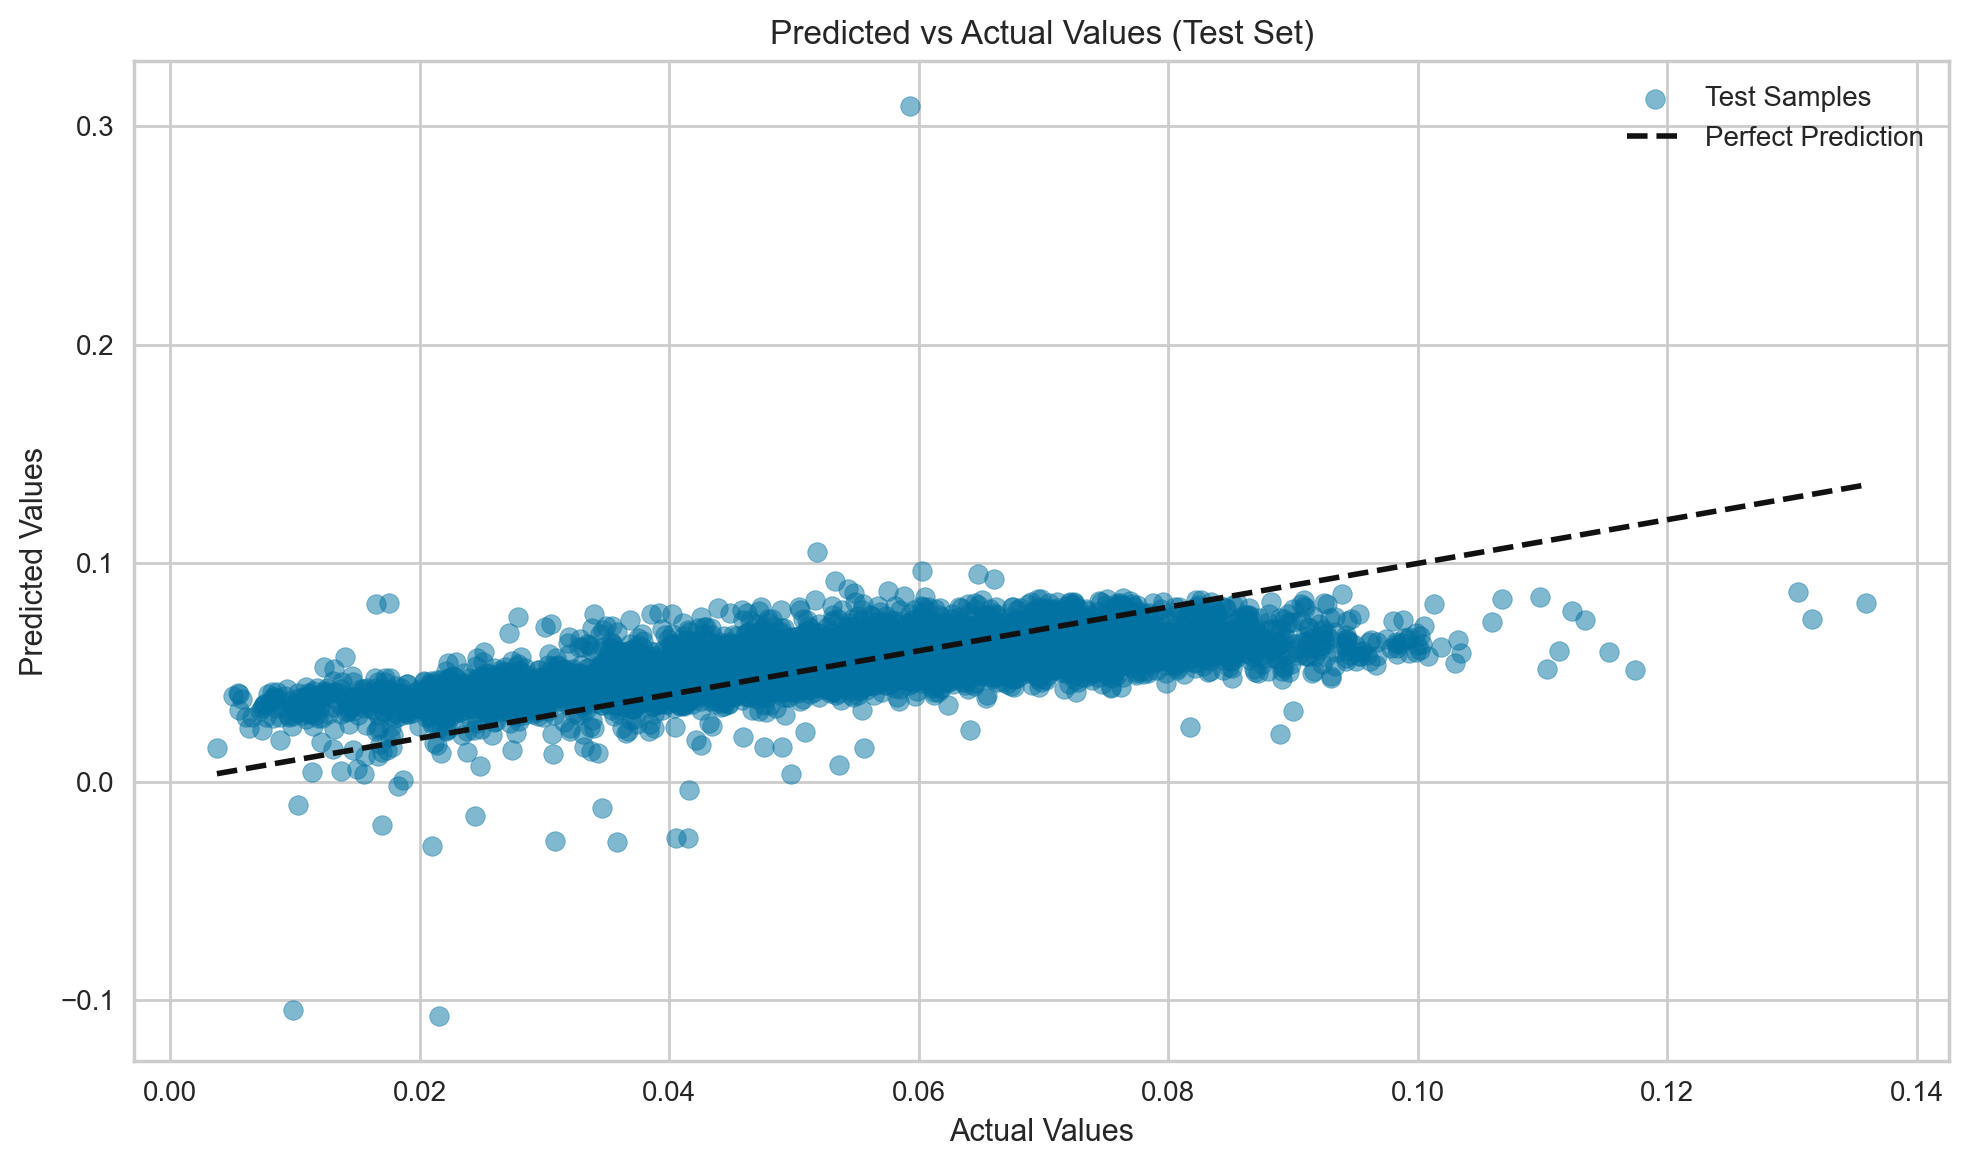

In [28]:
# Scatter plot of predicted vs actual on test - Non-PCA
plt.figure(figsize=(10, 6))
plt.scatter(y_test_sample, y_test_pred, alpha=0.5, label='Test Samples')
plt.plot([y_test_sample.min(), y_test_sample.max()], 
         [y_test_sample.min(), y_test_sample.max()], 
         'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
# Bootstrapped Confidence Intervals - Non-PCA
n_bootstraps = 1000  # Reduced from 10000 for speed
bootstrap_scores = []

for _ in range(n_bootstraps):
    # Resample with replacement
    X_bs, y_bs = resample(X_test_scaled_sample, y_test_sample)
    y_bs_pred = best_elastic_net_model.predict(X_bs)
    bootstrap_scores.append(r2_score(y_bs, y_bs_pred))

# Calculate confidence interval
ci_lower = np.percentile(bootstrap_scores, 2.5)
ci_upper = np.percentile(bootstrap_scores, 97.5)

print(f"\nBootstrap Confidence Intervals:")
print(f"Non-PCA Original R²: {test_r2:.3f}")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")


Bootstrap Confidence Intervals:
Non-PCA Original R²: 0.405
95% CI: [0.331, 0.453]


## XGB regression

In [77]:
# XGboost parameter grid
param_grid_xgb = {
    'regressor__n_estimators': np.arange(120,140),          # Fewer trees than classification
    'regressor__max_depth': np.arange(8,20),                  # Shallower trees often better for regression
    'regressor__learning_rate': np.arange(0.04,0.06,0.01),      # Smaller learning rates preferred
}

In [78]:
XGB_regressor = XGBRegressor(
    subsample=0.8,             # Slightly less than 1 for large datasets
    n_jobs=-1,
    random_state=2025
)

xgb = Pipeline(steps=[("regressor",XGB_regressor)])

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, refit=True,verbose=0)



In [80]:
np.random.seed(2025)  # For reproducibility
random_indices = np.random.choice(len(X_pca), size=10000, replace=False)
X_pca_sample = X_pca[random_indices]  # Sample for speed
y_pca_sample = y[random_indices]  # Sample for speed
grid_search_xgb.fit(X_pca_sample, y_pca_sample)

# best model pca
best_xgb_pca = grid_search_xgb.best_estimator_
print(f"\nBest parameters: {grid_search_xgb.best_params_}")
print(f"Best CV MSE: {-grid_search_xgb.best_score_:.4f}")

# test evaluation pca
y_test_pred_pca = best_xgb_pca.predict(X_test_pca)
test_mse_pca = mean_squared_error(y_test, y_test_pred_pca)
test_r2_pca = r2_score(y_test, y_test_pred_pca)
print(f"\nTest Performance:")
print(f"MSE: {test_mse_pca:.4f}")
print(f"R²: {test_r2_pca:.4f}")

KeyboardInterrupt: 

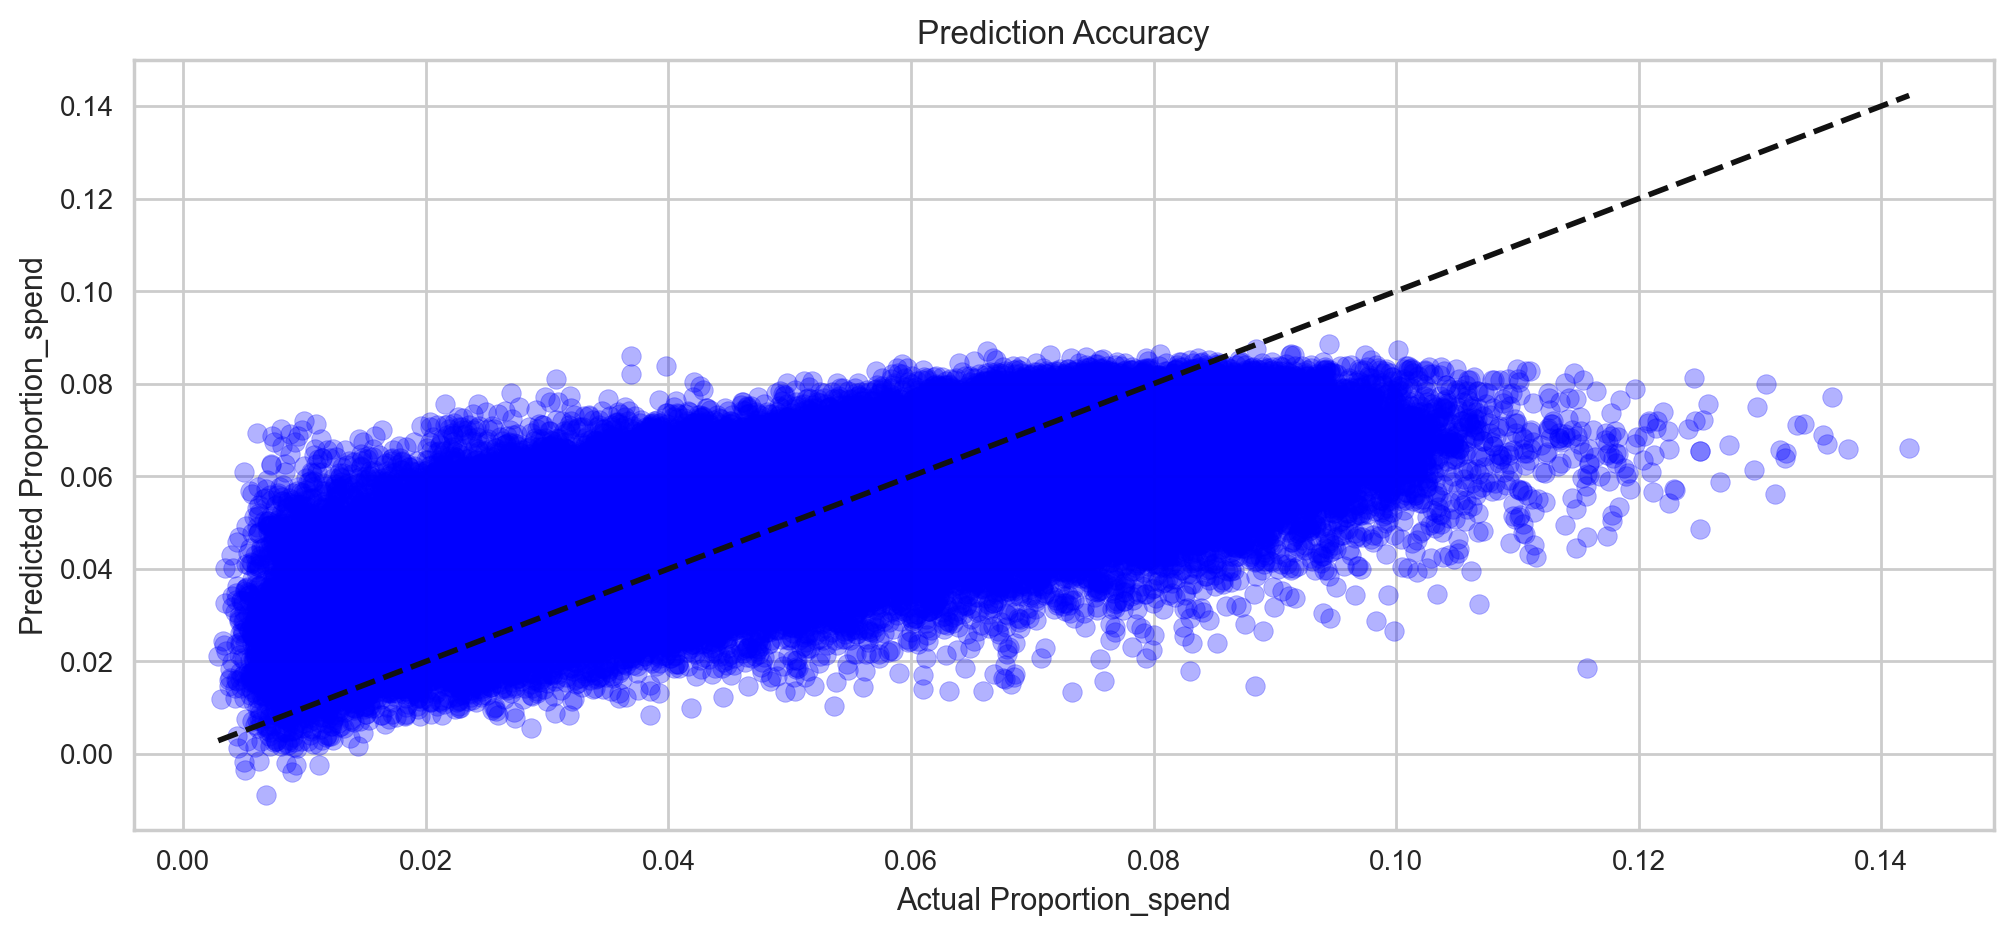

In [43]:
plt.figure(figsize=(12, 5))

# Predicted vs Actual
plt.scatter(y_test, y_test_pred_pca, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'k--', lw=2)
plt.xlabel('Actual Proportion_spend')
plt.ylabel('Predicted Proportion_spend')
plt.title('Prediction Accuracy')
plt.show()

In [45]:
# Bootstrap Confidence Interval for xgb
n_bootstraps = 500
bootstrap_r2 = []

for i in range(n_bootstraps):
    X_bs_pca, y_bs_pca = resample(X_test_pca, y_test, random_state=i)
    y_bs_pred_pca = best_xgb_pca.predict(X_bs_pca)
    bootstrap_r2.append(r2_score(y_bs_pca, y_bs_pred_pca))

ci_lower_pca, ci_upper_pca = np.percentile(bootstrap_r2, [2.5, 97.5])
print(f"\nBootstrap 95% CI for R²: [{ci_lower_pca:.3f}, {ci_upper_pca:.3f}]")


Bootstrap 95% CI for R²: [0.453, 0.460]


In [ ]:
param_grid_xgb = {
    'regressor__n_estimators': np.arange(120,140),          # Fewer trees than classification
    'regressor__max_depth': np.arange(8,20),                  # Shallower trees often better for regression
    'regressor__learning_rate': np.arange(0.04,0.06,0.01),      # Smaller learning rates preferred
}
np.random.seed(2025)  # For reproducibility
random_indices = np.random.choice(len(X_pca), size=10000, replace=False)
X_scaled_sample = X_scaled[random_indices]  # Sample for speed
y_sample = y[random_indices]  # Sample for speed
grid_search_xgb.fit(X_scaled_sample, y_sample) # XGB Boosting for non-PCA covariates

In [ ]:
The code in the `$SELECTION_PLACEHOLDER$` block is performing a grid search using `GridSearchCV` to find the best hyperparameters for the XGBoost model. This process can take a long time due to several factors:

1. **Large Parameter Grid**: The parameter grid (`param_grid_xgb`) includes multiple combinations of `n_estimators`, `max_depth`, and `learning_rate`. Each combination requires training and evaluating the model, which increases the computational cost.

2. **Cross-Validation**: The grid search uses 5-fold cross-validation (`cv=5`), meaning the model is trained and evaluated 5 times for each parameter combination. This multiplies the training time by the number of folds.

3. **Large Dataset**: The dataset being used (`X_scaled_sample` and `y_sample`) is large, even after sampling. Training XGBoost on a large dataset is computationally expensive, especially when using many trees (`n_estimators`).

4. **Complex Model**: XGBoost is a powerful but computationally intensive algorithm. It builds multiple decision trees iteratively, and the depth of the trees (`max_depth`) and the number of trees (`n_estimators`) significantly impact training time.

5. **Parallelism**: While `n_jobs=-1` is specified to use all available CPU cores, the computational cost can still be high if the parameter grid is large or the dataset is very large.

### Suggestions to Speed Up the Process:
1. **Reduce the Parameter Grid**: Narrow down the range of `n_estimators`, `max_depth`, and `learning_rate` based on prior knowledge or by running a smaller grid search first.

2. **Use RandomizedSearchCV**: Instead of `GridSearchCV`, use `RandomizedSearchCV` to sample a subset of the parameter grid. This can significantly reduce computation time.

3. **Reduce Dataset Size**: Use a smaller sample of the dataset for grid search. For example, you can reduce `X_scaled_sample` and `y_sample` further.

4. **Early Stopping**: Use XGBoost's `early_stopping_rounds` parameter to stop training trees early if the performance does not improve, reducing unnecessary computation.

5. **Distributed Computing**: If possible, use distributed computing frameworks like Dask or Spark to parallelize the grid search across multiple machines.

6. **Optimize Feature Set**: Reduce the number of features in the dataset using feature selection or dimensionality reduction (e.g., PCA) to speed up training.

By implementing these optimizations, you can significantly reduce the time required for the grid search.

In [ ]:
# best model - non-PCA
best_xgb = grid_search_xgb.best_estimator_
print(f"\nBest parameters: {grid_search_xgb.best_params_}")
print(f"Best CV MSE: {-grid_search_xgb.best_score_:.4f}")

np.random.seed(2025)  # For reproducibility
random_indices = np.random.choice(len(X_pca), size=40000, replace=False)
X_test_scaled_sample = X_test_scaled[random_indices]  # Sample for speed
y_test_sample = y_test[random_indices]  # Sample for speed

# test evaluation
y_test_pred = best_xgb.predict(X_test_scaled_sample)
test_mse = mean_squared_error(y_test_sample, y_test_pred)
test_r2 = r2_score(y_test_sample, y_test_pred)
print(f"\nTest Performance:")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")

In [ ]:
plt.figure(figsize=(12, 5))

# Predicted vs Actual
plt.scatter(y_test_sample, y_test_pred, alpha=0.3, color='blue')
plt.plot([y_test_sample.min(), y_test_sample.max()], 
         [y_test_sample.min(), y_test_sample.max()], 
         'k--', lw=2)
plt.xlabel('Actual Proportion_spend')
plt.ylabel('Predicted Proportion_spend')
plt.title('Prediction Accuracy')
plt.show()

### Comparing elastic net to xgboost

In [ ]:
# SHAP values for ElasticNet
explainer_elastic_net_pca = shap.Explainer(best_elastic_net_model_pca, X_pca)
shap_values_elastic_net_pca = explainer_elastic_net_pca(X_pca)

# Plot SHAP summary for ElasticNet
shap.summary_plot(shap_values_elastic_net_pca, X_pca, feature_names=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# SHAP values for XGBRegressor
explainer_xgb = shap.Explainer(best_xgb_pca.named_steps['regressor'], X_pca)
shap_values_xgb_pca = explainer_xgb(X_pca)

# Plot SHAP summary for XGBRegressor
shap.summary_plot(shap_values_xgb_pca, X_pca, feature_names=[f'PC{i+1}' for i in range(X_pca.shape[1])])